In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity.tsv', sep='\t', on_bad_lines='skip')
data_detail = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity_detail.tsv', sep='\t',on_bad_lines='skip')
data_assessment = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_assessments.tsv', sep='\t', on_bad_lines='skip')
data_assessment['school_year'] = data_assessment['script_name'].str[-4:]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 5.3 Predictive Modeling of Assessment Performance

1. **Feature Engineering**: Created new features `implementation_level`, `first_year_of_teaching`, `child_level_type`, and learning profile labels. 

2. **Model Training and Evaluation**: Leveraged linear regression and machine learning techniqes to predict student assessment scores. Calculated the MSE and R-Squared to evaluate the performance of the model.

3. **Feature Importance Analysis**: Interpreted the feature importance of the models to understand the relationship between the predictors and the target variable.


## Feature Engineering

Three features were generated from the raw data:

{code}`implementation_level`: Categorized teachers into 3 levels (low, medium, high) based on their cumulative activity over time using K-Means clustering. This helps differentiate teachers based on their experience levels.

{code}`first_year_of_teaching`: Indicated whether a teacher is teaching a particular course for the first time. This captures how teacher proficiency changes over time.

{code}`child_level_type`: Rpepresented the quiz item type, can be Multi (single-select multi choice), Multi2 (choose-two multi-choice), and Match (matching items)

### Teacher Implementation Level Clustering

This {code}`cluster_teachers_by_implementation` function processes data from activity dataset to categorize teachers based on their cumulative implementation levels over various school years. 

The implementation levels are determined by metrics such as the cumulative unique number of scripts assigned and the cumulative unique number of students they've interacted with up to a particular school year.

In [2]:
def compute_cumulative_unique(series):
    cumulative_list = []
    seen = set()
    for s in series:
        seen.update(s)
        cumulative_list.append(len(seen))
    return cumulative_list

def cluster_teachers_by_implementation(data):
    # Step 1: Preprocess the Data
    data_sorted = data.sort_values(by=['teacher_user_id', 'school_year'])

    # Step 2: Compute cumulative unique values for scripts and students
    cumulative_data = data_sorted.groupby(['teacher_user_id', 'school_year']).agg({
        'script_id': 'unique',
        'student_user_id': 'unique'
    }).reset_index()
    cumulative_data['cumulative_scripts'] = cumulative_data.groupby('teacher_user_id')['script_id'].transform(compute_cumulative_unique)
    cumulative_data['cumulative_students'] = cumulative_data.groupby('teacher_user_id')['student_user_id'].transform(compute_cumulative_unique)

    # Step 3: Scale the Metrics
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cumulative_data[['cumulative_scripts', 'cumulative_students']])

    # Step 4: Apply KMeans Clustering
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    cumulative_data['cluster_id'] = kmeans.fit_predict(scaled_data)

    # Step 5: Convert cluster IDs to labels
    cluster_labels = {0: 'Low', 2: 'Medium', 1: 'High'}
    cumulative_data['implementation_level'] = cumulative_data['cluster_id'].map(cluster_labels)
    cluster_membership_df = cumulative_data[['teacher_user_id', 'school_year', 'implementation_level']]
    cluster_membership_df['school_year'] = cluster_membership_df['school_year'].str[:4]
    
    return cluster_membership_df

implementation = cluster_teachers_by_implementation(data)
df_merged = pd.merge(data_assessment, implementation, on=['teacher_user_id', 'school_year'], how='left')

### Question Type and Teacher Experience Features

Previous descriptive analysis on assessment dataset has shown that correctness vary on course and question type, so here we extracted the feature {code}`child_level_type` to control for its impact.

In [3]:
# Calculate the difficulty coefficient for each course and parent level
difficulty_coefficients = data_assessment.groupby(['course_name', 'parent_level_type','child_level_type'])['answer_correct_flag'].apply(lambda x: (x == 'Y').mean()).reset_index()
difficulty_coefficients.columns = ['course_name', 'parent_level_type','child_level_type', 'difficulty_coefficient']
df_merged = pd.merge(df_merged, difficulty_coefficients, on=['course_name','parent_level_type','child_level_type',], how='left')

# Calculate the first year each teacher taught this course
first_year_taught = df_merged.groupby('teacher_user_id')['school_year'].min().reset_index()
first_year_taught.columns = ['teacher_user_id', 'first_year_taught']
df_merged = pd.merge(df_merged, first_year_taught, on='teacher_user_id', how='left')
# Create a new column to indicate whether the current year is the first year the teacher taught this course
df_merged['first_year_of_teaching'] = (df_merged['school_year'] == df_merged['first_year_taught']).astype(int) #1 represents is first year

# Replace 'Y' and 'N' in 'answer_correct_flag' with 1 and 0 respectively
df_merged['answer_correct_flag'] = df_merged['answer_correct_flag'].map({'Y': 1, 'N': 0})
df_model = df_merged[['teacher_user_id','course_name','school_year','parent_level_type','child_level_type','student_user_id','implementation_level','difficulty_coefficient','first_year_of_teaching','answer_correct_flag']]
df_model['difficulty_coefficient'] = 1 - df_model['difficulty_coefficient']

### Student Learning Behavior Features

In [4]:
# Calculating the time gap between created_at and updated_at timestamps
data_detail['created_at'] = pd.to_datetime(data_detail['created_at'])
data_detail['updated_at'] = pd.to_datetime(data_detail['updated_at'])
data_detail['time_gap'] = (data_detail['updated_at'] - data_detail['created_at']).dt.total_seconds() 
# Filtering the data based on the given criteria
filtered_data = data_detail[(data_detail['attempts'] != 0) & 
                     (data_detail['time_gap'] > 0) & 
                     (data_detail['time_gap'] <= 60*15)]

# Categorizing the test results based on provided breakdown
def categorize_test_result(result):
    if result < 20 and result != -1:
        return 'Failed'
    elif 20 <= result < 30:
        return 'Pass (Not Optimal)'
    elif 30 <= result < 1000:
        return 'Optimal'
    else:
        return 'Special'

filtered_data['test_result_category'] =filtered_data['best_result'].apply(categorize_test_result)
"""
# Identify Learning Behaviors for the filtered data
def assign_behavior_label(row):
    # Check for Rapid Guessing first
    if (row['attempts'] > 1) and (row['time_gap'] / row['attempts'] <= 5) and (row['test_result_category'] in ['Optimal', 'Pass (Not Optimal)']):
        return "Rapid Guessing"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Failed'):
        return "One-shot Failures"
    elif (row['attempts'] > 3) and (row['test_result_category'] == 'Failed'):
        return "Strugglers"
    elif row['test_result_category'] == 'Pass (Not Optimal)':
        return "Suboptimal Success"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Optimal'):
        return "Succeed at First Trial"
    elif (row['attempts'] > 3) and (row['time_gap'] > 60) and (row['test_result_category'] == 'Optimal'):
        return "Consistent Learner"
    else:
        return "Others"
"""  
def assign_behavior_label(row):
    # Check for Rapid Guessing first
    if (row['attempts'] > 1) and (row['time_gap'] / row['attempts'] <= 5) and (row['test_result_category'] in ['Optimal', 'Pass (Not Optimal)']):
        return "Rapid Guessing"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Failed'):
        return "One-shot Failures"
    elif (row['attempts'] > 3) and (row['test_result_category'] == 'Failed'):
        return "Strugglers"
    elif row['test_result_category'] == 'Pass (Not Optimal)':
        return "Suboptimal Success"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Optimal'):
        return "Succeed at First Trial"
    elif (row['attempts'] >= 3) and (row['time_gap'] > 59) and (row['test_result_category'] == 'Optimal'): #both over 50%
        return "Consistent Learner"
    else:
        return "Others"
    
filtered_data['behavior_label'] = filtered_data.apply(assign_behavior_label, axis=1)

# Counting occurrences of each label
behavior_counts = filtered_data['behavior_label'].value_counts()

# convert counts to proportion to standardize the data
grouped_data = filtered_data.groupby(['student_user_id', 'school_year', 'behavior_label']).size().unstack().reset_index().fillna(0)
grouped_data.iloc[:, 2:] = grouped_data.iloc[:, 2:].div(grouped_data.iloc[:, 2:].sum(axis=1), axis=0)

# Standardizing the data
scaler = StandardScaler()
grouped_data.iloc[:, 2:] = scaler.fit_transform(grouped_data.iloc[:, 2:])
grouped_data['school_year'] = grouped_data['school_year'].str[:4]

In [5]:
df_model = pd.merge(df_model, grouped_data, on=['student_user_id','school_year'], how='left')
df_model.head()

,teacher_user_id,course_name,school_year,parent_level_type,child_level_type,student_user_id,implementation_level,difficulty_coefficient,first_year_of_teaching,answer_correct_flag,Consistent Learner,One-shot Failures,Others,Rapid Guessing,Strugglers,Suboptimal Success,Succeed at First Trial
0,24529224,csd,2017,Gamelab,Multi,33728229,High,0.64523,1,0.0,-0.945497,-0.026028,0.655204,0.984262,-0.235071,-0.450502,-0.30247
1,24529224,csd,2017,Gamelab,Multi,33718947,High,0.64523,1,1.0,-1.047306,-0.026028,0.668506,-0.483908,1.368678,-0.450502,-0.30247
2,24529224,csd,2017,Gamelab,Multi,29432841,High,0.64523,1,0.0,-0.679255,-0.026028,0.960175,0.238762,-0.466998,-0.450502,-0.30247
3,24529224,csd,2017,Gamelab,Multi,33752236,High,0.64523,1,0.0,-0.993994,-0.026028,1.486539,-0.248622,-0.466998,-0.450502,-0.30247
4,24529224,csd,2017,Gamelab,Multi,33752305,High,0.64523,1,0.0,-0.868710,-0.026028,1.591301,-0.636637,-0.466998,-0.450502,-0.30247


## Model Training and Evaluation

1. Split the data into training and testing sets.

2. Train Linear Regression, Random Forest, Gradient Boosting, and Neural Network models.

3. Evaluate the models on the test set using metrics like MAE, MS, RMSE and R-Squared.

### Model Selection

| Model                         | Description                                                                                                 | Characteristics                                                                                               |
|-------------------------------|-------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|
| Linear Regression             | Models the linear relationship between the dependent and independent variables.                             | Adv: Simple, interpretable.<br>Disadv: Assumes linear relationships; Sensitive to outliers.                 |
| Random Forest Regressor       | Ensemble method using multiple decision trees.                                                              | Adv: Handles linear/non-linear data; Less prone to overfitting.<br>Disadv: Can be computationally intensive. |
| Gradient Boosting Regressor   | Boosting technique that builds trees sequentially.                                                          | Adv: High predictive accuracy; Captures subtle patterns.<br>Disadv: Requires tuning; Can overfit noisy data. |
| Support Vector Regression (SVR) | Regression technique to find hyperplanes in high dimensional space.                                          | Adv: Effective in high-dimensional spaces; Models non-linear relationships.<br>Disadv: Needs data scaling; Kernel and parameter choice crucial. |
| Ridge Regression              | Linear regression with L2 regularization.                                                                   | Adv: Counters multicollinearity; Prevents overfitting.<br>Disadv: Might not provide feature selection.      |
| Lasso Regression              | Linear regression with L1 regularization.                                                                   | Adv: Can result in feature selection.<br>Disadv: Might underfit with excessive regularization.            |
| Neural Network                | Comprises layers of interconnected nodes.                                                                   | Adv: Models complex relationships; Flexible.<br>Disadv: Needs more data; Black-box nature; Computationally intensive. |

In [6]:
data_cleaned = df_model.dropna()

# Feature Engineering: Aggregate answer_correct_flag
aggregated_data = data_cleaned.groupby(['teacher_user_id', 'course_name', 'school_year', 
                                        'parent_level_type', 'child_level_type', 'student_user_id'])['answer_correct_flag'].mean().reset_index()
aggregated_data.rename(columns={'answer_correct_flag': 'avg_answer_correct'}, inplace=True)

# Merging aggregated_data with data_cleaned
merged_data = pd.merge(aggregated_data, data_cleaned.drop(columns=['answer_correct_flag']), 
                       on=['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 
                           'child_level_type', 'student_user_id'], 
                       how='left').drop_duplicates()

# Encode categorical variables
cols_to_drop = ['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 'student_user_id', 'avg_answer_correct','difficulty_coefficient','Others']
merged_data_encoded = pd.get_dummies(merged_data.drop(columns=cols_to_drop), columns=['implementation_level', 'child_level_type'])

X = merged_data_encoded
y = merged_data['avg_answer_correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

### Model Performance

In [7]:
# Train regression models
linear_reg = LinearRegression().fit(X_train, y_train)
rf_reg = RandomForestRegressor(random_state=36).fit(X_train, y_train)
gbm_reg = GradientBoostingRegressor(random_state=36).fit(X_train, y_train)
svr_reg = SVR().fit(X_train, y_train)
ridge_reg = Ridge().fit(X_train, y_train)
lasso_reg = Lasso().fit(X_train, y_train)
nn_reg = MLPRegressor(max_iter=1000, random_state=36).fit(X_train, y_train)

linear_preds = linear_reg.predict(X_test)
rf_preds = rf_reg.predict(X_test)
gbm_preds = gbm_reg.predict(X_test)
svr_preds = svr_reg.predict(X_test)
ridge_preds = ridge_reg.predict(X_test)
lasso_preds = lasso_reg.predict(X_test)
nn_preds = nn_reg.predict(X_test)

regression_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Regression', 'Ridge Regression', 'Lasso Regression', 'Neural Network'],
    'MAE': [mean_absolute_error(y_test, linear_preds), mean_absolute_error(y_test, rf_preds), mean_absolute_error(y_test, gbm_preds), mean_absolute_error(y_test, svr_preds), mean_absolute_error(y_test, ridge_preds), mean_absolute_error(y_test, lasso_preds), mean_absolute_error(y_test, nn_preds)],
    'MSE': [mean_squared_error(y_test, linear_preds), mean_squared_error(y_test, rf_preds), mean_squared_error(y_test, gbm_preds), mean_squared_error(y_test, svr_preds), mean_squared_error(y_test, ridge_preds), mean_squared_error(y_test, lasso_preds), mean_squared_error(y_test, nn_preds)],
    'RMSE': [mean_squared_error(y_test, linear_preds, squared=False), mean_squared_error(y_test, rf_preds, squared=False), mean_squared_error(y_test, gbm_preds, squared=False), mean_squared_error(y_test, svr_preds, squared=False),mean_squared_error(y_test, ridge_preds, squared=False), mean_squared_error(y_test, lasso_preds, squared=False), mean_squared_error(y_test, nn_preds, squared=False)],
    'R-squared': [r2_score(y_test, linear_preds), r2_score(y_test, rf_preds), r2_score(y_test, gbm_preds), r2_score(y_test, svr_preds),r2_score(y_test, ridge_preds), r2_score(y_test, lasso_preds), r2_score(y_test, nn_preds)]
}

performance_df_reg = pd.DataFrame(regression_metrics)


In [8]:
performance_df_reg

,Model,MAE,MSE,RMSE,R-squared
0,Linear Regression,0.312055,0.134970,0.367383,0.167158
1,Random Forest,0.295157,0.141233,0.375809,0.128515
2,Gradient Boosting,0.284917,0.121339,0.348338,0.251268
3,Support Vector Regression,0.280131,0.135936,0.368695,0.161196
4,Ridge Regression,0.312097,0.134972,0.367386,0.167144
5,Lasso Regression,0.351759,0.162388,0.402974,-0.002027
6,Neural Network,0.285009,0.126396,0.355522,0.220067


**Gradient Boosting** and **Neural Network** models demonstrate superior performance compared to the baseline Linear Regression model for this dataset.


## Feature Importance Analysis

Feature importance plots for Gradient Boosting and Neural Network are presetned since they are the two best-performaing models.

### Feature Importance Plots

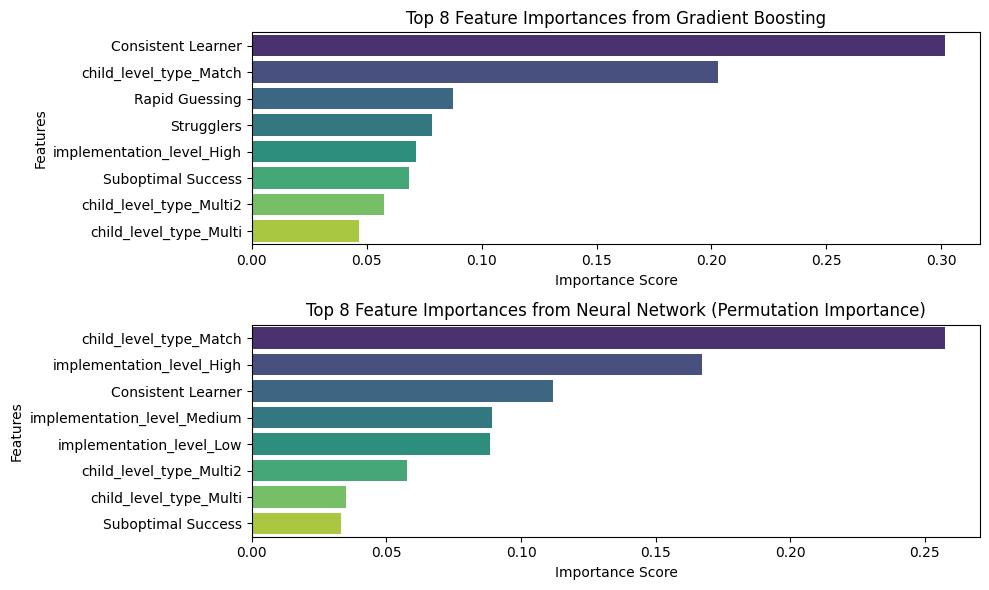

In [9]:
gb_feature_importance = gbm_reg.feature_importances_
# Extracting feature importance for Neural Network (using permutation importance)
nn_perm_importance = permutation_importance(nn_reg, X_test, y_test, n_repeats=30, random_state=36)
nn_feature_importance = nn_perm_importance.importances_mean

# Creating DataFrames for visualization
gb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_feature_importance
}).sort_values(by='Importance', ascending=False)

nn_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': nn_feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualizing the feature importances
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Gradient Boosting feature importance
sns.barplot(x='Importance', y='Feature', data=gb_importance_df.head(8), ax=axes[0], palette='viridis')
axes[0].set_title('Top 8 Feature Importances from Gradient Boosting')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Features')

# Neural Network feature importance
sns.barplot(x='Importance', y='Feature', data=nn_importance_df.head(8), ax=axes[1], palette='viridis')
axes[1].set_title('Top 8 Feature Importances from Neural Network (Permutation Importance)')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

### Visualizing Gradient Boosting Importance: SHAP

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and effects, taking into account the interaction effects among features. It gives a value for each feature for each prediction, indicating the direction and magnitude of the feature's effect.

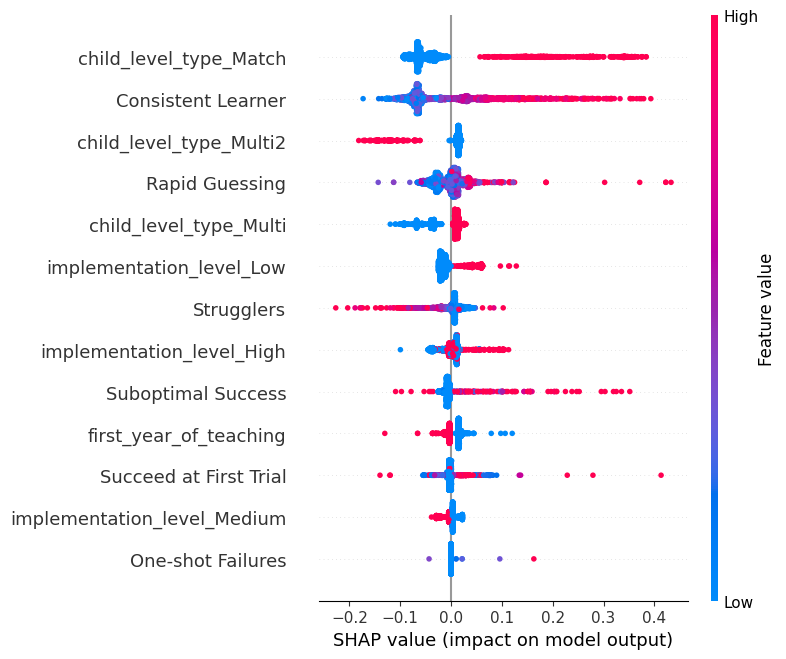

In [10]:
# Compute SHAP values for Gradient Boosting Regressor
explainer_gbm = shap.TreeExplainer(gbm_reg)
shap_values_gbm = explainer_gbm.shap_values(X_train)
shap.summary_plot(shap_values_gbm, X_train)

  0%|          | 0/417 [00:00<?, ?it/s]

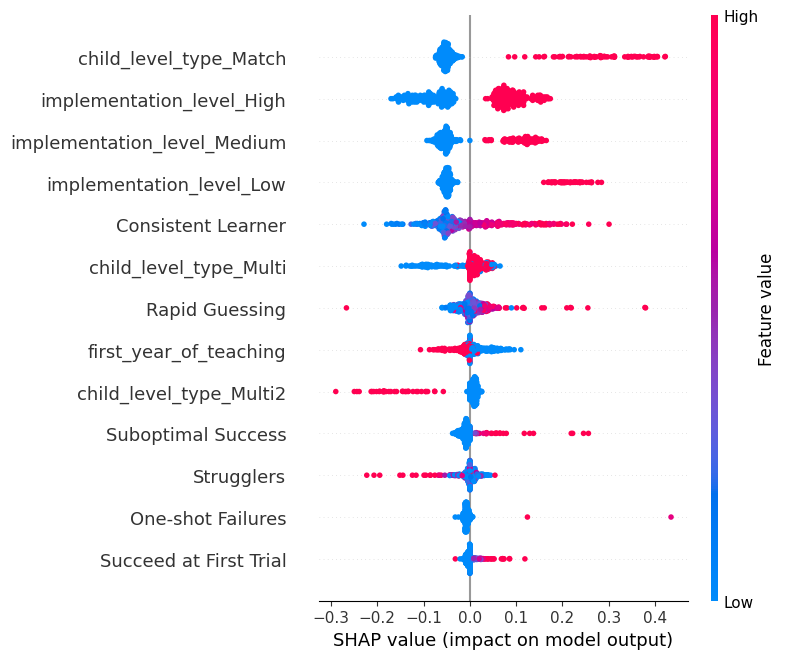

In [11]:
# For the Neural Network model using KernelExplainer
nn_background_data = shap.sample(X_train, 100)  # Randomly sample 100 instances from training data as background data
nn_explainer = shap.KernelExplainer(nn_reg.predict, nn_background_data)
nn_shap_values = nn_explainer.shap_values(X_test, nsamples=100)  # Using 100 Monte Carlo samples

shap.summary_plot(nn_shap_values, X_test)

**Vertical Axis**: Each row on the y-axis corresponds to a feature in the dataset.
Features at the top are the most influential, with significance decreasing as you move downwards.

**Horizontal Axis**: Represents the SHAP value for each feature. The further a dot is from the center, the greater its impact on the prediction.
Right of Center (positive values): Features that push the prediction higher.
Left of Center (negative values): Features that push the prediction lower.

**Color**: The color intensity signifies the magnitude of the feature value.
Red Dots: High feature values. For example, <u> red dots on the right suggests that high values of this feature increase the assessment scores </u>.
Blue Dots: Low feature values. For example, <u> blue dots on the right suggests that low values of this feature increase the assessment scores </u>.

A mix of red and blue dots spread across both sides indicates that the feature can either increase or decrease the prediction, depending on its value and potential interactions with other features. For instance, both very high and very low values of a feature might increase the prediction, while mid-range values decrease it.

## Conclusion

`````{admonition} Insights
:class: tip

1. **Dominance of Question Types**: 
    The predominant role of question types is evident, with 'matching' and 'single choice' emerging as strong positive predictors of scores. This aligns with finding from assessment section where matching question is the easiest type of question, followed by single-choice question.

2. **Student Learning Profiles Matter**: 
    Beyond the inherent question type, it's evident that a student's daily activity engagement patterns can predict their assessment scores. The profiles 'consistent learner' is positively associated with assessment scores. Students who made more than three attempts, took longer time gaps (more than 60 seconds between attempts), and eventually reached optimal results, were positively correlated with better assessment outcomes. This group represents learners who might not succeed initially but exhibit a pattern of progressive improvement without resorting to rapid guessing.

3. **Concerning Learning Patterns**: 
    In contrast, the 'struggler' profile negatively correlates with performance, indicating that students who failed more than three times and spent over one minute on the platform were found to be at risk. Targeted support may help remediate these learner needs.

4. **Potential Misconceptions Addressed**: 
    Interestingly, isolated instances of either a single failure or immediate success didn't significantly impact the overall assessment results. Further investigation is needed to explore the nuances of these behaviors.

`````
These findings underscore the importance of perseverance and sustained effort in achieving positive learning outcomes. **The path to mastery appears more predictive than isolated setbacks or fluctuations.** Supporting students in forging consistent engagement and gradual improvement, rather than overreacting to temporary setbacks or spikes, may therefore be beneficial. However, further research is needed to establish causal mechanisms underlying these associations.

## **Key Insights**

### Nurturing Consistent Learners:
**Educators & Curriculum Designers**: 
  - The positive correlation between 'consistent learners' and better outcomes underscores the importance of fostering a learning environment that values persistence. Instead of focusing solely on immediate results, curriculums can be designed to reward progressive improvements, encouraging students to embrace learning as a journey rather than a destination.
    
**EdTech Platforms**: 
  - Tools and platforms can be designed to provide feedback over time, highlighting students' progression and areas of steady improvement. This can motivate students to persevere, recognizing that their consistent efforts are being acknowledged.

### Interventions for Struggling Students:
**Teachers & Instrcutors**: 
  - Identifying students who consistently struggle and take longer than usual can be crucial. Interventions, such as additional tutoring sessions or supplementary resources, can be recommended for these students to address their specific challenges.

### Reassessing Single-Event Judgments:
**Educators & School Administrators**: 
  - The non-significant correlation between one-time failures/successes and overall outcomes challenges the traditional notion of labeling students based on isolated incidents. Continuous assessment, rather than a singular reliance on one-time tests, can provide a more holistic understanding of a student's learning.
    
**Test & Quiz Designers**: 
  - Incorporate a mix of questions that assess both immediate comprehension and the ability to learn from mistakes. This ensures that students who might not get things right initially but have the potential to learn and improve aren't unfairly penalized.

### Leveraging Learning Analytics:
**EdTech Companies & Platform Developers**: 
  - Educational platforms enabled by data mining and learning analytics techniques offer opportunities to automatically detect student learning patterns and surface actionable insights in real time. Developers could embed early alert systems and trigger notifications when algorithms identify students requiring timely interventions, allowing educators to provide targeted support. 
    
**Research & Academic Communities**: 
  - Continued research in the intersection of education and technology can provide deeper insights into evolving student behaviors, especially in the digital age. Collaborative efforts between researchers and educators can lead to more effective teaching strategies tailored to the needs of modern students.
